In [2]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
from matplotlib import pyplot as plt

import torchsummary
import os
import time
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# args = parser.parse_args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch



In [4]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [19]:
# Model
print('==> Building model..')
class SE(nn.Module):
    '''Squeeze-and-Excitation block.'''

    def __init__(self, in_planes, se_planes):
        super(SE, self).__init__()
        self.se1 = nn.Conv2d(in_planes, se_planes, kernel_size=1, bias=True)
        self.se2 = nn.Conv2d(se_planes, in_planes, kernel_size=1, bias=True)

    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, (1, 1))
        out = F.relu(self.se1(out)) # squeeze
        out = self.se2(out).sigmoid() # excitation
        out = x * out # inception and resnet(reweight)
        return out

class Block(nn.Module):
    def __init__(self, w_in, w_out, stride, group_width, bottleneck_ratio, se_ratio):
        super(Block, self).__init__()
        # 1x1
        w_b = int(round(w_out * bottleneck_ratio)) # the middle layer is slim, to end is thick so it is like a bottleneck
        self.conv1 = nn.Conv2d(w_in, w_b, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(w_b)
        # 3x3
        num_groups = w_b // group_width #Group the corresponding input channels and number of output channels
        self.conv2 = nn.Conv2d(w_b, w_b, kernel_size=3,
                               stride=stride, padding=1, groups=num_groups, bias=False)
        self.bn2 = nn.BatchNorm2d(w_b)
        # se
        self.with_se = se_ratio > 0
        if self.with_se:
            w_se = int(round(w_in * se_ratio))
            self.se = SE(w_b, w_se)
        # 1x1
        self.conv3 = nn.Conv2d(w_b, w_out, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(w_out)

        self.shortcut = nn.Sequential()
        if stride != 1 or w_in != w_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(w_in, w_out,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(w_out)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        if self.with_se:
            out = self.se(out)
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class RegNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(RegNet, self).__init__()
        self.cfg = cfg
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(0)
        self.layer2 = self._make_layer(1)
        self.layer3 = self._make_layer(2)
        self.layer4 = self._make_layer(3)
        self.linear = nn.Linear(self.cfg['widths'][-1], num_classes)

    def _make_layer(self, idx):
        depth = self.cfg['depths'][idx]
        width = self.cfg['widths'][idx]
        stride = self.cfg['strides'][idx]
        group_width = self.cfg['group_width']
        bottleneck_ratio = self.cfg['bottleneck_ratio']
        se_ratio = self.cfg['se_ratio']

        layers = []
        for i in range(depth):
            s = stride if i == 0 else 1
            layers.append(Block(self.in_planes, width,
                                s, group_width, bottleneck_ratio, se_ratio))
            self.in_planes = width
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

==> Building model..


In [8]:
cfg = {
    'depths': [1, 4, 8, 12],
    'widths': [32, 64, 160, 416],
    'strides': [1, 1, 2, 2],
    'group_width': 16,
    'bottleneck_ratio': 0.5,
    'se_ratio': 0.25,
    'lr': 0.01,
    'resume': False
    }

In [9]:
# Specify the net
net = RegNet(cfg)
net = net.to(device)
torchsummary.summary(net,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 16, 32, 32]           1,024
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7             [-1, 16, 1, 1]             272
            Conv2d-8             [-1, 16, 1, 1]             272
                SE-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]             512
      BatchNorm2d-11           [-1, 32, 32, 32]              64
           Conv2d-12           [-1, 32, 32, 32]           2,048
      BatchNorm2d-13           [-1, 32, 32, 32]              64
            Block-14           [-1, 32,

In [10]:
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if cfg['resume']:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=args.lr, betas=(0.9, 0.999),
#                        eps=1e-08,weight_decay=0,amsgrad=False)       
optimizer = optim.SGD(net.parameters(), lr=cfg['lr'],
                      momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 30, T_mult=2, eta_min = 0, last_epoch = -1, verbose = False)

In [11]:
# Training
def train(epoch):

    # print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

    train_loss = train_loss / len(trainloader)
    train_acc = 100.*correct / total

    return train_loss, train_acc

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        test_loss = test_loss / len(testloader)
        test_acc = 100.*correct/total

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

    return test_loss, test_acc

In [12]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [13]:
train_loss_history = []
test_loss_history = []

EPOCHS = 200
for epoch in range(start_epoch, EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    scheduler.step()
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc:.2f} | Best Acc:{best_acc:.2f}%')

Saving..
Epoch: 01 | Epoch Time: 1m 12s
	Train Loss: 2.585 | Train Acc: 13.97%
	 Test. Loss: 2.856 |  Test. Acc: 11.73 | Best Acc:11.73%
Saving..
Epoch: 02 | Epoch Time: 1m 10s
	Train Loss: 1.984 | Train Acc: 22.32%
	 Test. Loss: 2.034 |  Test. Acc: 19.27 | Best Acc:19.27%
Saving..
Epoch: 03 | Epoch Time: 1m 11s
	Train Loss: 1.801 | Train Acc: 29.79%
	 Test. Loss: 2.018 |  Test. Acc: 31.11 | Best Acc:31.11%
Epoch: 04 | Epoch Time: 1m 11s
	Train Loss: 1.574 | Train Acc: 40.79%
	 Test. Loss: 2.863 |  Test. Acc: 29.46 | Best Acc:31.11%
Saving..
Epoch: 05 | Epoch Time: 1m 11s
	Train Loss: 1.368 | Train Acc: 50.08%
	 Test. Loss: 1.954 |  Test. Acc: 50.63 | Best Acc:50.63%
Epoch: 06 | Epoch Time: 1m 10s
	Train Loss: 1.164 | Train Acc: 58.25%
	 Test. Loss: 2.125 |  Test. Acc: 50.22 | Best Acc:50.63%
Saving..
Epoch: 07 | Epoch Time: 1m 11s
	Train Loss: 1.011 | Train Acc: 64.09%
	 Test. Loss: 1.196 |  Test. Acc: 60.83 | Best Acc:60.83%
Saving..
Epoch: 08 | Epoch Time: 1m 9s
	Train Loss: 0.872 |

In [ ]:
filename = "output\lr\lr=0.1_t0=20.txt"
output = open('data.txt','w',encoding = 'gbk')
for i in range(len(train_loss_history)):
    rowtxt = '{},{}'.format(train_loss_history[i],test_loss_history[i])
    output.write(rowtxt)
    output.write('\n')
output.close()

In [18]:
checkpoint = torch.load('./checkpoint/ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']
test_loss, test_acc = test(1)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Test Loss: 0.163 | Test Acc: 95.00%


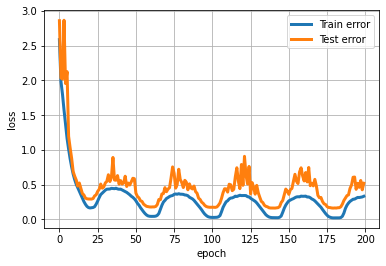

In [14]:
plt.plot(range(start_epoch + 200), train_loss_history, '-', linewidth=3, label = 'Train error')
plt.plot(range(start_epoch + 200), test_loss_history, '-', linewidth=3, label = 'Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()